***CHÚ Ý***: Tìm hiêu xem số chiều của resnet với mỗi filter là bao nhiêu, liệu ảnh kích thước đầu vào đúng chưa, các layer làm gì, nhất là các layer cuối cùng

kiểm tra xem đã shuffle data sau mỗi epoch chưa

liệu có flatten quá sớm không

thử bỏ dropout, regu ở lớp conv, chỉ để ở FC vì:
* hiệu quả chưa đc kiểm chứng
* batchnorm đã làm phần nào regu rồi

tại sao model của keras không giảm loss đc?

tại sao model res11, res50 lại cho loss tệ hơn cái model tempt??????

mae vs mse

kiểm chứng: nhìn chung mình sẽ thêm layer/unit đến khi nào cái val loss ko thể bé hơn được nữa. Còn về L2 thì thực ra nó có hiệu ứng gần như early stopping, khi loss chạm đến cực tiểu thì mình dừng học ở early stop, cũng như tiếp tụ học ở L2 nhưng thy đổi của các tham số chỉ xoay quanh cá giá trị mà mình dừng ở early stopping thôi. Còn cái dropout hôm nọ tra thì có người nói nó giống ensemble hơn là regu

[callbacks](https://towardsdatascience.com/tensorflow-callbacks-how-to-monitor-neural-network-training-like-a-pro-f02cb4e477d0) model checkpoint, CSVLogger

test dataset

data augmentation



MAE/MSE/RMSE


chiến lược:


* Xác định trước xem train/val loss/accuracy trước và sau khi hiệu chỉnh là bao nhiêu. Quan trọng vì để xác định khi nào thì đã đủ overfit
* tạo 1 kiến trúc đơn giản.
 * đảm bảo nó overfit trên tập dữ liệu rất bé trước.
 * nếu không thể overfit trên tập dữ liệu lớn:
   * thử các chiến lực giảm learning rate khác nhau (coarse cho nhiều lr trước). Nếu không được:
   * dùng thuật toán tối ưu khác (coarse cho nhiều **tổ hợp** optimizer + lr trước): Adam, SGD, Adadelta (do có thể đang mắc ở các điểm saddle). Nếu không được:
   * thử kiến trúc phức tạp hơn

* Sau khi đảm bảo overfit trên toàn bộ tập dữ liệu rồi: thêm hiệu chỉnh/drop out.
 * đảm bảo nó overfit trên tập dữ liệu rất bé trước.
 * nếu bị underfit trên toàn tập dữ liệu:
   * thử giảm learning rate (coarse...). Nếu không được:
   * dùng các thuật toán tối ưu khác (coarse...). Nếu không được:
   * kiểm tra xem lambda có bị lớn quá không. Nếu không được:
   * thử kiến trúc khác phức tạp hơn



In [75]:
# from google.colab import drive
# drive.mount('/content/drive')

### Import

In [76]:
!git clone https://github.com/LapTQ/facial_beauty_perception
%cd facial_beauty_perception/FBP5500/Images

Cloning into 'facial_beauty_perception'...
remote: Enumerating objects: 11423, done.
remote: Counting objects: 100% (11423/11423), done.
remote: Compressing objects: 100% (11408/11408), done.
remote: Total 11423 (delta 262), reused 11033 (delta 12), pack-reused 0
Receiving objects: 100% (11423/11423), 188.45 MiB | 21.60 MiB/s, done.
Resolving deltas: 100% (262/262), done.
Checking out files: 100% (11020/11020), done.
/content/facial_beauty_perception/FBP5500/Images/facial_beauty_perception/FBP5500/Images


In [77]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
from sklearn.model_selection import train_test_split


from tensorflow.keras.preprocessing import image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization, Conv2D, Activation, Add, Input, Dense, ZeroPadding2D, Flatten, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from keras.initializers import he_normal
from keras.regularizers import L1, L2
from keras.models import Model

import pathlib
import tempfile
import shutil

from IPython import display

from tensorflow.keras.optimizers import Adam, SGD, Adadelta, RMSprop, Nadam
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers


seed = 42

In [78]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

### Load images

In [292]:
#@title Choose hyper-parameter
image_size = 224 #@param [224] {allow-input: true} {type:"integer"}

batch_size = 32 #@param [32, 64, 128, 256]

channels = "1" #@param [1, 3]

image_size = (image_size, image_size)
batch_size = int(batch_size)
channels = int(channels)

input_shape = (image_size, image_size, channels)

scores_path = "https://github.com/LapTQ/facial_beauty_perception/raw/main/FBP5500/train_test_files/All_labels.csv"

scores_dataframe = pd.read_csv(
    scores_path,
    header=None,
    names=['file_name', 'score']
)

scores = scores_dataframe['score'].to_numpy().tolist()

count    5500.000000
mean        2.990891
std         0.688112
min         1.016667
25%         2.500000
50%         2.833333
75%         3.533333
max         4.750000
Name: score, dtype: float64


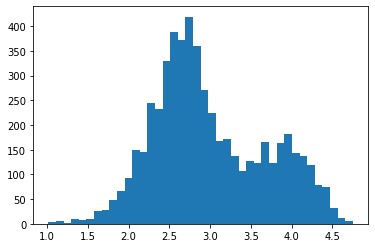

In [81]:
print(scores_dataframe['score'].describe())

plt.hist(scores_dataframe['score'], bins=40)
plt.show()

In [82]:
############################################# xem xét xóa đoạn code này
genders = [scores_dataframe['file_name'][index][1] for index in scores_dataframe.index]
genders = np.array(genders)
set_seed(seed)
np.random.shuffle(genders)

In [294]:
############################################# xem xét xóa đoạn code này
images = []
for index in scores_dataframe.index:
    img = image.load_img(scores_dataframe['file_name'][index], target_size=image_size, color_mode="grayscale" if channels == 1 else 'rgb')
    img = image.img_to_array(img)
    images.append(img)

In [295]:
############################################# xem xét xóa đoạn code này
images = np.array(images)
scores = np.array(scores)

set_seed(seed)
np.random.shuffle(images)
set_seed(seed)
np.random.shuffle(scores)

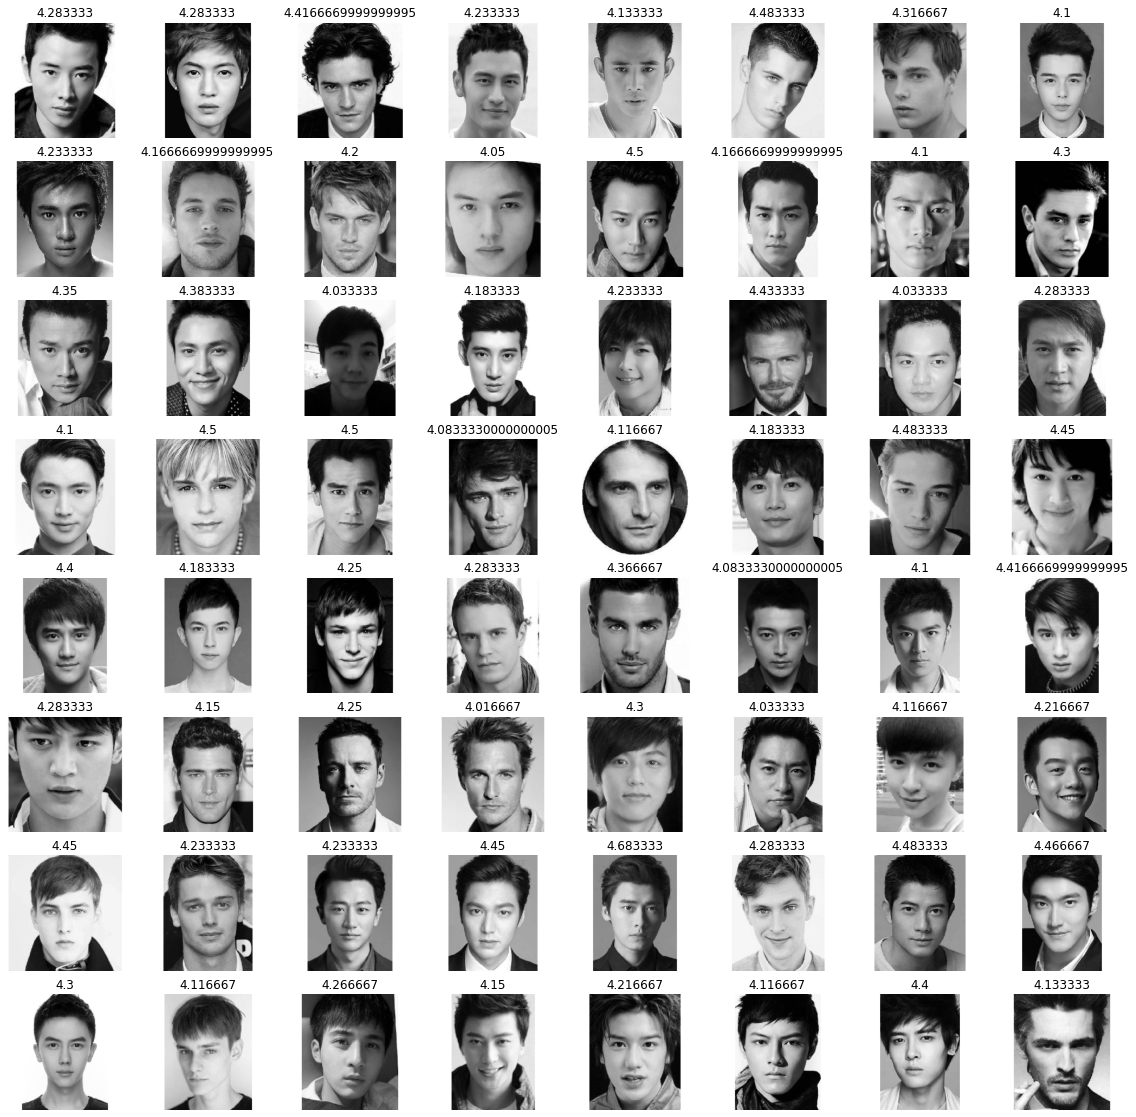

In [296]:
#@title Show some images and their beauty score
group = '5' #@param [1, 2, 3, 4, 5]
n = 64 #@param {type:"integer"}
shift = 0 #@param {type:"integer"}
gender = 'Male' #@param ['Female', 'Male']

group = int(group)
gender = gender[0]

group = int(group)

def plot_faces(group, n, shift, gender):
    i = j = 0
    plt.figure(figsize=(20, 20))
    while i < 64:
        if shift + j < 5500 and group - 1 < scores[shift + j] <= group and genders[shift + j] == gender:
            ax = plt.subplot(8, 8, i + 1)
            if channels == 1:
                plt.imshow(np.squeeze(images[shift + j]), cmap='gray')
            else:
                plt.imshow(images[shift + j])
            plt.title(scores[shift + j])
            plt.axis("off")
            i += 1
        
        j += 1

plot_faces(group, n, shift, gender)

### Create dataset

In [89]:
# n_train = 4400
# v_validation = 1100
# buffer_size = 4400

In [90]:
# DEPRICATED 1

# images_ds = tf.data.Dataset.from_tensor_slices(images)
# scores_ds = tf.data.Dataset.from_tensor_slices(scores)

# x_train = images_ds.take(n_train)
# x_val = images_ds.skip(n_train)

# y_train = scores_ds.take(n_train)
# y_val = scores_ds.skip(n_train)

In [91]:
# DEPRICATED 1

# x_val_prefetch = x_val.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
# x_train_prefetch = x_train.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# y_val_prefetch = y_val.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
# y_train_prefetch = y_train.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [92]:
# ds = tf.data.Dataset.from_tensor_slices((images, scores))

# train_ds = ds.take(n_train)
# val_ds = ds.skip(n_train)

In [93]:
# steps_per_epoch = {'tiny': 5,
#                    'small': 27,
#                    'medium': 64,
#                    'large': 100,
#                    'all': n_train//batch_size}

In [94]:
# def get_dataset(batch_size, dataset_size='all'):
#     set_seed(seed)
#     if dataset_size == 'all':
#         return (train_ds.cache().shuffle(buffer_size, seed, reshuffle_each_iteration=True).repeat().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE),
#                 val_ds.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
#                 )
#     else:
#         return (train_ds.take(steps_per_epoch[dataset_size]).cache().shuffle(buffer_size, seed, reshuffle_each_iteration=True).repeat().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE),
#                 val_ds.take(steps_per_epoch[dataset_size]).cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
#                 )

In [ ]:
# def generator():
#     for index in train_scores_df.index:
#         img = image.load_img(train_scores_df['file_name'][index], target_size=image_size)#, color_mode="grayscale")
#         img = image.img_to_array(img)
#         yield img/255., train_scores_df['score'][index]

# train_ds = tf.data.Dataset.from_generator(
#     generator,
#     output_types=(tf.float32, tf.float32),
#     output_shapes=((*image_size, 3), tuple())
# ).cache().shuffle(buffer_size=5500, reshuffle_each_iteration=True).batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)

# ################ chưa có cho tập rất bé


# train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
#              num_parallel_calls=tf.data.AUTOTUNE)
# # data_augmentation(train_ds)

In [285]:
#@title Choose validation size split ratio
test_size = 0.2 #@param {allow-input: true}

train_scores_df, val_scores_df = train_test_split(scores_dataframe, test_size=test_size, shuffle=True, random_state=seed)

print('%d images for training' % (len(train_scores_df)))
print('%d images for validation' % (len(val_scores_df)))

4400 images for training
1100 images for validation


In [297]:
def filename_to_img(filename, label):
    img_string = tf.io.read_file(filename)
    
    # Don't use tf.image.decode_image, or the output shape will be undefined
    img = tf.image.decode_jpeg(img_string, channels=channels)

    # This will convert to float values in [0, 1]
    # img = tf.image.convert_image_dtype(img, tf.float32)

    # img = tf.image.resize(img, image_size)

    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((train_scores_df['file_name'], train_scores_df['score']))
val_ds = tf.data.Dataset.from_tensor_slices((val_scores_df['file_name'], val_scores_df['score']))

train_ds = train_ds.map(filename_to_img, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(filename_to_img, num_parallel_calls=tf.data.AUTOTUNE)

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=5000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

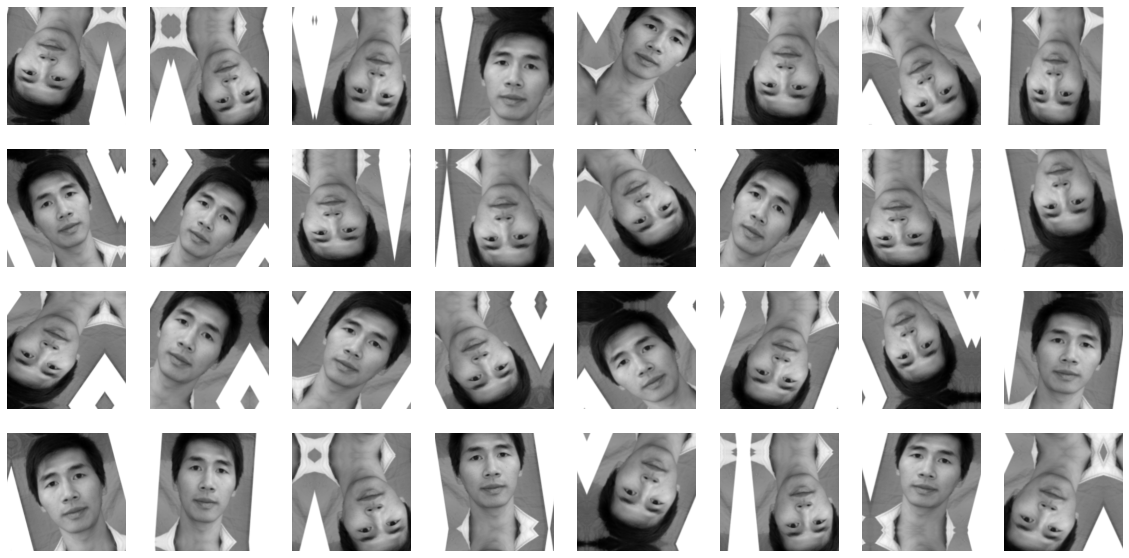

In [298]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.Resizing(*image_size),
  tf.keras.layers.Rescaling(1./255), # use offset=-1 if wanted it to be [-1, 1]
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomContrast(0.5),
  tf.keras.layers.RandomZoom(0.08, 0.08),
  tf.keras.layers.RandomTranslation(0.2, 0.2)
])

plt.figure(figsize=(20, 10))
for img, sco in train_ds.take(1):
    for i in range(32):
        augmented_image = data_augmentation(img)
        ax = plt.subplot(4, 8, i + 1)
        if channels == 1:
            plt.imshow(np.squeeze(augmented_image[0], axis=-1), cmap='gray')
        else:
            plt.imshow(augmented_image[0])
        plt.axis("off")

### Utilities

In [38]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [39]:
models = {}
lr_record = {}
epoch_record = {}
histories = {}

In [40]:
def remove_model(name):
    try:
        del models[name]
        del histories[name]
        del lr_record[name]
        del epoch_record[name]
    except:
        pass

In [265]:
############################### handle trường hợp tiny data

def train_model(name, optimizer, max_epochs, monitor='val_nonregu_mae', reduce_lr_patience, early_stop_patience, checkpoint_name):

    print(name)

    # if dataset_size == 'all': steps_per_epoch['all'] = n_train//batch_size

    # train_data, validation_data = get_dataset(batch_size, dataset_size)

    callbacks = [
                 tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=reduce_lr_patience, verbose=1),
                 tf.keras.callbacks.EarlyStopping(monitor=monitor, min_delta=0.00001, patience=early_stop_patience, verbose=1),
                #  tf.keras.callbacks.TensorBoard(logdir/name)
                ]

    if checkpoint_name is not None:
        callbacks.append(tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/checkpoint/{}.hdf5'.format(checkpoint_name), monitor=monitor, verbose=1, save_best_only=True))
    
    shutil.rmtree(logdir/name, ignore_errors=True)     

    new_model = True
    if name in histories.keys() and input("'{}' already exists. Override? [y/n] ".format(name)) != 'y':
        new_model = False
    
    set_seed(seed)

    if new_model:

        models[name].compile(
            optimizer=optimizer,
            loss='mean_absolute_error',
            metrics=[tf.keras.losses.MeanAbsoluteError(name='nonregu_mae')]
        )

        histories[name] = models[name].fit(
            train_ds,
            steps_per_epoch=train_ds.cardinality(),
            epochs=max_epochs,
            validation_data=val_ds,
            callbacks=callbacks,
            shuffle=True
        )

        epoch_record[name] = [histories[name].epoch[-1]]
        lr_record[name] = [optimizer.get_config()['learning_rate']]

    else:

        models[name].optimizer.learning_rate.assign(optimizer.get_config()['learning_rate'])

        cont_history = models[name].fit(
            train_ds, 
            steps_per_epoch=train_ds.cardinality(),
            epochs=max_epochs,     
            validation_data=val_ds,    
            callbacks=callbacks,
            initial_epoch=histories[name].epoch[-1] + 1
        )

        epoch_record[name].append(cont_history.epoch[-1])
        lr_record[name].append(optimizer.get_config()['learning_rate'])
        histories[name].epoch += cont_history.epoch
        histories[name].history['loss'] += cont_history.history['loss']
        histories[name].history['val_loss'] += cont_history.history['val_loss']
        histories[name].history['nonregu_mae'] += cont_history.history['nonregu_mae']
        histories[name].history['val_nonregu_mae'] += cont_history.history['val_nonregu_mae']

    return name

In [42]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-1gzrskv0
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-1gzrskv0
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=155817 sha256=fbaa7036808de3482fa08dac5697dc7dc88fff4eb343482c304263b7aab1afd5
  Stored in directory: /tmp/pip-ephem-wheel-cache-d80h4c0g/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [43]:
plotter = tfdocs.plots.HistoryPlotter(
    metric = 'nonregu_mae',
    smoothing_std=10
)

In [44]:
def loss(model, x, y, training=False):
    mae = tf.keras.losses.MeanAbsoluteError()
    y_pred = model(x, training=training)
    return mae(y_true=y, y_pred=y_pred)

def grad(model, x, y):
    with tf.GradientTape() as tape:
        loss_value = loss(model, x, y, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [45]:
def plot_activations(model, img):
    """
    Arguments:
        model
        img -- numpy array of shape (height, width, channel)
    """
    activations = [model.layers[0](np.expand_dims(img, axis=0))]      # Input layer
    for layer in model.layers[1:13]:         # 14th layer not match input shape because of shortcut
        # print("Inputing shape: {} to {} with expected input shape: {}".format(activations[-1].shape, layer.name, layer.input_shape))
        activations.append(layer(activations[-1], training=False))

    # plot activation distribution
    plt.figure(figsize=(20, 10))
    for i in range(len(activations)):
        plt.subplot(2, 7, i + 1)
        plt.title(model.layers[i].name)
        plt.tight_layout()
        plt.hist(activations[i].numpy().reshape(-1,), bins=20)

In [46]:
def plot_layer_filter(name, layer=0):
    shape = models[name].layers[layer].get_weights()[0].shape
    figure_shape = (math.ceil(shape[-1]/16), 16)
    plt.figure(figsize=(4/3*figure_shape[1], 4/3*figure_shape[0]))
    for i in range(shape[-1]):
        plt.subplot(*figure_shape, i + 1)
        plt.imshow(models[name].layers[layer].get_weights()[0][...,0, i], cmap='gray')     # just plot the 1st channel of a filter volume in the layer
        plt.axis('off')
    plt.show()

In [47]:
def plot_layer_output(name, layer=0, image_index=0):
    outputs = [np.expand_dims(images[image_index], axis=0)]
    for i in range(len(models[name].layers)):
        outputs.append(models[name].layers[i](outputs[-1]))
    
    shape = outputs[layer + 1].shape    # plot each channel of that layer
    figure_shape = (math.ceil(shape[-1]/16), 16)
    plt.figure(figsize=(4/3*figure_shape[1], 4/3*figure_shape[0]))
    for i in range(shape[-1]):
        plt.subplot(*figure_shape, i + 1)
        plt.imshow(np.squeeze(outputs[layer + 1][..., i]), cmap='gray')
        plt.axis("off")
    plt.show()

### Testing

#### plot activation distribution

In [ ]:
model = ResNet11(input_shape)
plot_activations(model, images[1])

#### Xác định

Regu|Train loss| Test loss
-|-|-
có|0.01|0.05
không|0.001|

In [ ]:
keras.models.clone_model(models['ResNet50_Adam_lr_0.0005']).save('/content/drive/MyDrive/overfit_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/overfit_model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# models['ResNet50_Adam_lr_0.0005'] = tf.keras.models.load_model('/content/drive/MyDrive/overfit_model')

In [ ]:
# import pickle
# import sys
# sys.setrecursionlimit(15000)
# history_dict = {name: histories[name].history for name in histories.keys()}
# with open('/content/drive/MyDrive/histories', 'wb') as file_pi:
#         pickle.dump(history_dict, file_pi)
# history_dict = pickle.load(open('/content/drive/MyDrive/histories', 'rb'))

#### Thử mô hình tự tạo :((

In [ ]:
def get_model():
    return tf.keras.models.Sequential([
        Conv2D(50, (5, 5), input_shape=input_shape, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(100, (5, 5), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(150, (4, 4), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(200, (4, 4), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(250, (4, 4), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(300, (2, 2), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(500, activation='relu'),#, kernel_constraint=maxnorm(3))
        Dense(5),#, activation='softmax', kernel_constraint=maxnorm(3))
        Dense(1)#, activation='sigmoid')
    ])

get_model().summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 220, 220, 50)      1300      
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 110, 110, 50)     0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 106, 106, 100)     125100    
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 53, 53, 100)      0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 50, 50, 150)       240150    
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 25, 25, 150)     

In [ ]:
optimizer = SGD(learning_rate=1e-3, momentum=0.9, nesterov=True)

model = get_model()

name = '{}_{}_lr_{}'.format(model.name, optimizer.get_config()['name'], optimizer.get_config()['learning_rate'])
models[name] = model

In [ ]:
optimizer = SGD(learning_rate=1e-6, momentum=0.9, nesterov=True)
train_model(name, optimizer, max_epochs=150, monitor='nonregu_mae', reduce_lr_patience=5, dataset_size='tiny')

sequential_SGD_lr_0.001
'sequential_SGD_lr_0.001' already exists. Override? [y/n] 
Epoch 101/150
5/5 [==============================] - 3s 708ms/step - loss: 4.8390e-04 - nonregu_mae: 4.8390e-04 - val_loss: 0.5187 - val_nonregu_mae: 0.5187 - lr: 1.0000e-06
Epoch 102/150
5/5 [==============================] - 3s 688ms/step - loss: 3.8641e-04 - nonregu_mae: 3.8641e-04 - val_loss: 0.5187 - val_nonregu_mae: 0.5187 - lr: 1.0000e-06
Epoch 103/150
5/5 [==============================] - 3s 681ms/step - loss: 2.4922e-04 - nonregu_mae: 2.4922e-04 - val_loss: 0.5184 - val_nonregu_mae: 0.5184 - lr: 1.0000e-06
Epoch 104/150
5/5 [==============================] - 3s 672ms/step - loss: 6.2076e-04 - nonregu_mae: 6.2076e-04 - val_loss: 0.5187 - val_nonregu_mae: 0.5187 - lr: 1.0000e-06
Epoch 105/150
5/5 [==============================] - 3s 669ms/step - loss: 3.4943e-04 - nonregu_mae: 3.4943e-04 - val_loss: 0.5186 - val_nonregu_mae: 0.5186 - lr: 1.0000e-06
Epoch 106/150
5/5 [============================

'sequential_SGD_lr_0.001'

{'ResNet11_SGD_lr_1e-06': [9.999999e-12], 'sequential_SGD_lr_0.001': [1.0000001e-06, 1e-06]}
{'ResNet11_SGD_lr_1e-06': [72], 'sequential_SGD_lr_0.001': [99, 136]}


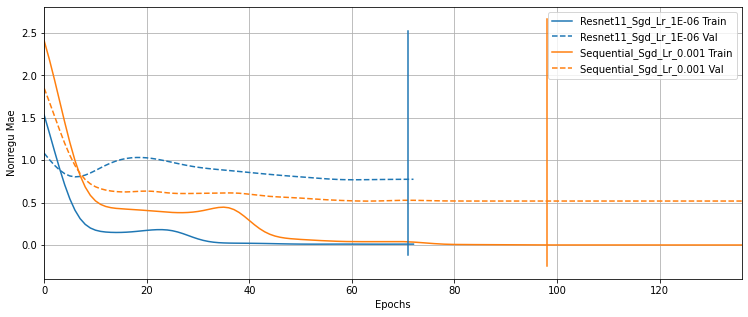

In [ ]:
plt.figure(figsize=(12.5, 5))
plotter.plot(histories)
epoch_set = set()
for name in epoch_record.keys():
    epoch_set.update(set(epoch_record[name]))
epoch_set = sorted(list(epoch_set))
for i in range(len(epoch_set) - 1):
    plt.plot([epoch_set[i] - 1, epoch_set[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([140, 170])
# plt.ylim([0.00665, 0.006725])
plt.xlabel('Epochs')
print(lr_record)
print(epoch_record)

#### Thử overfit temptmodel trên tập đầy đủ

In [ ]:
remove_model('sequential_SGD_lr_0.001')

In [ ]:
optimizer = Adam(learning_rate=5e-4)

model = get_model()

name = '{}_{}_lr_{}'.format(model.name, optimizer.get_config()['name'], optimizer.get_config()['learning_rate'])
models[name] = model

In [ ]:
optimizer = Adam(learning_rate=5e-4)
train_model(name, optimizer, max_epochs=100, monitor='nonregu_mae', reduce_lr_patience=5, batch_size=64)

sequential_7_Adam_lr_0.0005
'sequential_7_Adam_lr_0.0005' already exists. Override? [y/n] 
Epoch 9/100
68/68 [==============================] - 28s 410ms/step - loss: 0.4137 - nonregu_mae: 0.4137 - val_loss: 0.4349 - val_nonregu_mae: 0.4308 - lr: 5.0000e-04
Epoch 10/100
68/68 [==============================] - 28s 408ms/step - loss: 0.3978 - nonregu_mae: 0.3978 - val_loss: 0.4027 - val_nonregu_mae: 0.4001 - lr: 5.0000e-04
Epoch 11/100
68/68 [==============================] - 28s 408ms/step - loss: 0.4233 - nonregu_mae: 0.4233 - val_loss: 0.3891 - val_nonregu_mae: 0.3868 - lr: 5.0000e-04
Epoch 12/100
68/68 [==============================] - 28s 408ms/step - loss: 0.4053 - nonregu_mae: 0.4053 - val_loss: 0.3802 - val_nonregu_mae: 0.3788 - lr: 5.0000e-04
Epoch 13/100
68/68 [==============================] - 28s 409ms/step - loss: 0.3823 - nonregu_mae: 0.3823 - val_loss: 0.3737 - val_nonregu_mae: 0.3710 - lr: 5.0000e-04
Epoch 14/100
68/68 [==============================] - 28s 408ms/step -

'sequential_7_Adam_lr_0.0005'

{'sequential_7_Adam_lr_0.0005': [0.0005, 0.0005]}
{'sequential_7_Adam_lr_0.0005': [7, 99]}


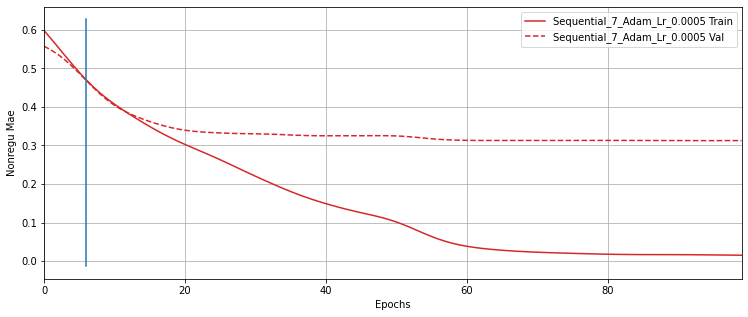

In [ ]:
plt.figure(figsize=(12.5, 5))
plotter.plot(histories)
epoch_set = set()
for name in epoch_record.keys():
    epoch_set.update(set(epoch_record[name]))
epoch_set = sorted(list(epoch_set))
for i in range(len(epoch_set) - 1):
    plt.plot([epoch_set[i] - 1, epoch_set[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([140, 170])
# plt.ylim([0.00665, 0.006725])
plt.xlabel('Epochs')
print(lr_record)
print(epoch_record)

có vẻ overfit được với tập dữ liệu gốc rồi

#### Thêm regu

In [37]:
def get_model_v2():
    return tf.keras.models.Sequential([
        Conv2D(44, (11, 11), input_shape=input_shape, activation='relu', strides=2),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Conv2D(88, (5, 5), activation='relu'),
        Conv2D(88, (5, 5), activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Conv2D(132, (5, 5), activation='relu', padding='same'),
        Conv2D(132, (5, 5), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Conv2D(264, (5, 5), activation='relu', padding='same'),
        Conv2D(264, (5, 5), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Flatten(),
        Dense(500, activation='relu'),
        Dense(5, activation='relu'),
        Dense(1)
    ])

def get_model_v3():
    return tf.keras.models.Sequential([
        Conv2D(16, (11, 11), input_shape=input_shape, activation='relu', strides=2),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Conv2D(32, (5, 5), activation='relu', padding='same'),
        Conv2D(64, (5, 5), activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Conv2D(128, (5, 5), activation='relu', padding='same'),
        Conv2D(256, (5, 5), activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Conv2D(512, (5, 5), activation='relu', padding='same'),
        # Conv2D(512, (5, 5), activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Flatten(),
        Dense(500, activation='relu'),
        Dense(5, activation='relu'),
        Dense(1)
    ])

def get_model_v4():
    return tf.keras.models.Sequential([
        Conv2D(16, (11, 11), input_shape=input_shape, activation='relu', strides=2),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Conv2D(32, (7, 7), activation='relu', padding='same'),
        Conv2D(64, (7, 7), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Conv2D(128, (7, 7), activation='relu', padding='same'),
        Conv2D(256, (7, 7), activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Conv2D(512, (7, 7), activation='relu', padding='same'),
        # Conv2D(512, (5, 5), activation='relu'),
        # MaxPooling2D(pool_size=(3, 3), strides=2),
        Flatten(),
        Dense(500, activation='relu'),
        Dense(5, activation='relu'),
        Dense(1)
    ])

get_model_v4().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 107, 107, 16)      1952      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 53, 53, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 53, 53, 32)        25120     
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 64)        100416    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 26, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 128)       4

In [ ]:
models['checkpoint'] = get_model_v2()

In [ ]:
models['checkpoint'].load_weights('/content/drive/MyDrive/checkpoint/checkpoint2.hdf5')

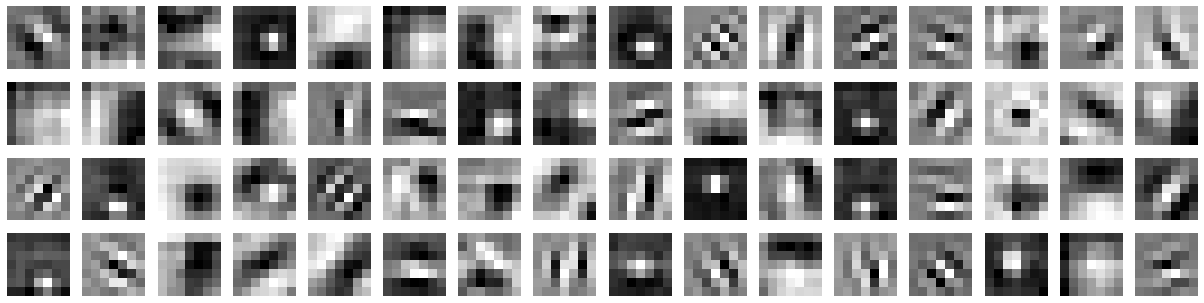

In [ ]:
plot_layer_filter('pretrained_model', layer=2)

In [ ]:
list(enumerate(models['pretrained_model'].layers))

In [ ]:
plot_layer_output('pretrained_model', layer=2, image_index=0)

In [ ]:
optimizer = Adam(learning_rate=1e-3)

model = get_model_v4()

name = '{}_{}_lr_{}'.format(model.name, optimizer.get_config()['name'], optimizer.get_config()['learning_rate'])
models[name] = model

In [ ]:
optimizer = Adam(learning_rate=1e-3)
train_model(name, optimizer, max_epochs=150, monitor='val_nonregu_mae', reduce_lr_patience=10, batch_size=64, checkpoint='checkpoint3')

{'finetune_model': [0.001]}
{'finetune_model': [25]}


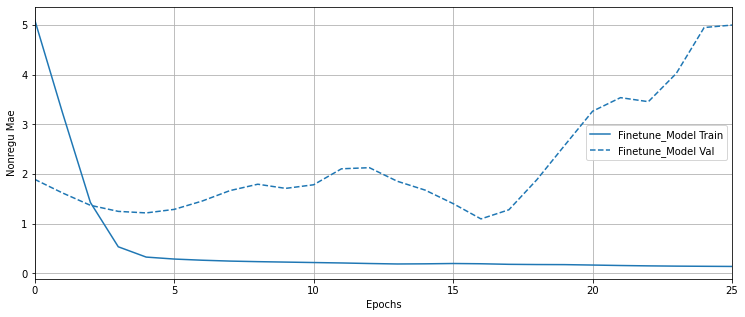

In [ ]:
plt.figure(figsize=(12.5, 5))
plotter.plot(histories)
epoch_set = set()
for name in epoch_record.keys():
    epoch_set.update(set(epoch_record[name]))
epoch_set = sorted(list(epoch_set))
for i in range(len(epoch_set) - 1):
    plt.plot([epoch_set[i] - 1, epoch_set[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([140, 170])
# plt.ylim([0.00665, 0.006725])
plt.xlabel('Epochs')
print(lr_record)
print(epoch_record)

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    shear_range=0.2,
    validation_split=0.2,
    brightness_range=(0.75, 1),
    zoom_range=0.2,
)

train_gen = datagen.flow_from_dataframe(
    dataframe=scores_dataframe, 
    x_col='file_name', 
    y_col='score', 
    target_size=image_size,
    color_mode='grayscale',
    class_mode='raw',
    batch_size=64,
    shuffle=True,
    seed=seed,
    subset='training'
)

val_gen = datagen.flow_from_dataframe(
    dataframe=scores_dataframe, 
    x_col='file_name', 
    y_col='score', 
    target_size=image_size,
    color_mode='grayscale',
    class_mode='raw',
    batch_size=64,
    shuffle=True,
    seed=seed,
    subset='validation'
)

Found 4400 validated image filenames.
Found 1100 validated image filenames.


In [ ]:
def get_model_v4():
    return tf.keras.models.Sequential([
        Conv2D(filters= 96, kernel_size= (11,11), strides=(4,4), padding='valid', input_shape = (224,224,3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(3,3), strides=(2,2)),
        BatchNormalization(),
        Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', kernel_regularizer=L2(0.0005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'),
        BatchNormalization(),
        Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=L2(0.0005)),
        Activation('relu'),
        BatchNormalization(),
        Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=L2(0.0005)),
        Activation('relu'),
        BatchNormalization(),
        Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=L2(0.0005)),
        Activation('relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'),
        
        # Conv2D(512, (5, 5), activation='relu'),
        # MaxPooling2D(pool_size=(3, 3), strides=2),
        Flatten(),
        Dense(units = 1024, activation = 'relu'),
        Dropout(0.5),
        Dense(units = 1024, activation = 'relu'),
        Dropout(0.5),
        Dense(5, activation='relu'),
        Dense(1)
    ])

base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=input_shape)
x = Flatten()(base_model.layers[-1].output)
x = Dense(100, activation='relu')(x)
x = Dense(50, activation='relu')(x)
x = Dense(25, activation='relu')(x)
x = Dense(1)(x)
model = Model(inputs=base_model.input, outputs=x)
# model.summary()
model.compile(Adam(learning_rate=5e-3), loss='mean_absolute_error')
history = model.fit(
    train_gen,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=1),
               tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=14, verbose=1),
               tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.00001, patience=15, verbose=1),
               tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/checkpoint/checkpoint3.hdf5', monitor='val_loss', verbose=1, save_best_only=True)],
    steps_per_epoch=4400//64,
    epochs=75,
    validation_data=val_gen,
    use_multiprocessing=True
    # initial_epoch=
)

In [ ]:
base_model =  tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = Flatten()(base_model.layers[-1].output)
x = Dense(100, activation='relu')(x)
x = Dense(50, activation='relu')(x)
x = Dense(5, activation='relu')(x)
x = Dense(1)(x)

models['finetune_model'] = Model(inputs=base_model.input, outputs=x)

for i in range(6):
    models['finetune_model'].layers[i].trainable = False

# models['finetune_model'].summary()

name = 'finetune_model'

In [ ]:
optimizer = Adam(learning_rate=8e-4)
train_model(name, optimizer, max_epochs=50, monitor='val_nonregu_mae', reduce_lr_patience=3, early_stop_patience=10, batch_size=64)#, checkpoint='checkpoint3')

In [112]:
ds = tf.data.Dataset.from_generator(
    lambda: generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=((32,224,224,1), (32,))
)

ds.element_spec

(TensorSpec(shape=(32, 224, 224, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(32,), dtype=tf.float32, name=None))

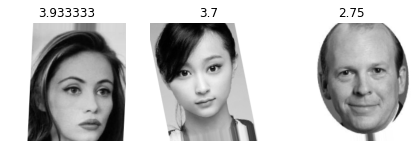

In [ ]:
batch = datagen.flow(images[:3], scores[:3], batch_size=3)
plt.figure(figsize=(20, 10))
img, sco = next(batch)
for i in range(3):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(np.squeeze(img[i]), cmap='gray')
    plt.title(sco[i])
    plt.axis("off")

In [ ]:
img, sco in nex

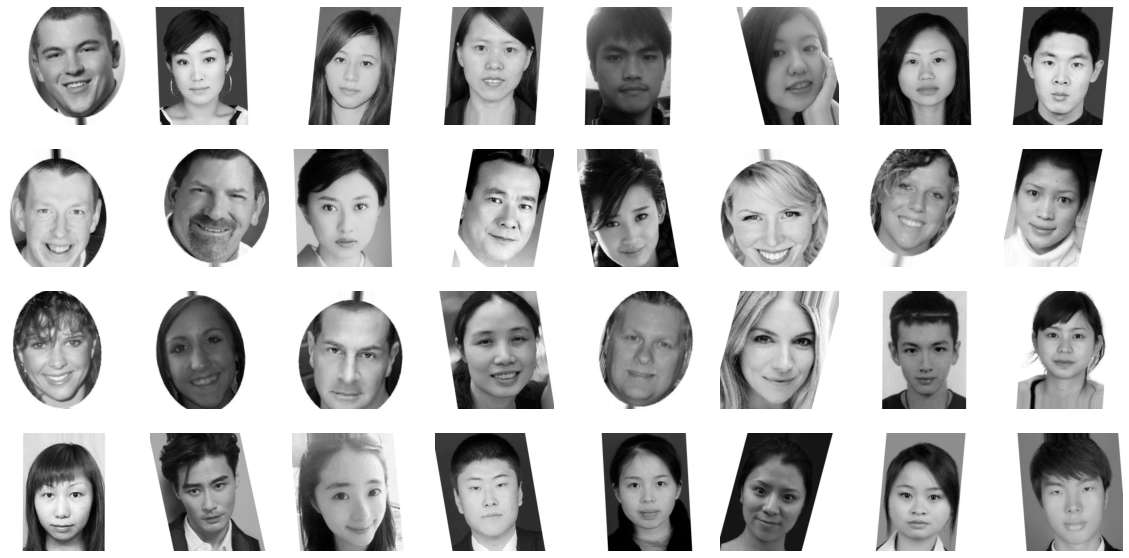

In [ ]:
# img, sco = next(k)
plt.figure(figsize=(20, 10))
for img, sco in ds.take(1):
  for i in range(32):
      ax = plt.subplot(4, 8, i + 1)
      plt.imshow(np.squeeze(img[i]), cmap='gray')
      # plt.title(sco[i])
      plt.axis("off")
plt.show()

#### Thử overfit ResNet11 trên tập dữ liệu rất bé

===> có vẻ như ResNet11 không thể overfit đến mức 0.001 train loss được, thử optimizer khác có lẽ cũng không được chắc phải tăng capacity

#### Tạo ResNet50 (do không overfit tập rất bé được)

In [ ]:
def ResNet50(input_shape=input_shape):

    set_seed(seed)

    X_input = Input(input_shape)

    X = ZeroPadding2D(padding=3)(X_input)

    # define the input as a tensor
    X_input= Input(input_shape)

    # zero-padding
    X = ZeroPadding2D(padding=3)(X_input)

    # stage 1
    X = Conv2D(filters=64, kernel_size=7, strides=2, kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=3, strides=2)(X)

    # stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1)
    X = identity_block(X, f=3, filters=[64, 64, 256])
    X = identity_block(X, f=3, filters=[64, 64, 256])

    # stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2)
    X = identity_block(X, f=3, filters=[128, 128, 512])
    X = identity_block(X, f=3, filters=[128, 128, 512])
    X = identity_block(X, f=3, filters=[128, 128, 512])

    # stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], s=2)
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])

    # stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], s=2)
    X = identity_block(X, f=3, filters=[512, 512, 2048])
    X = identity_block(X, f=3, filters=[512, 512, 2048])

    # average pooling layer
    X = AveragePooling2D(pool_size=2, strides=1, name="avg_pool")(X)
    X = Flatten()(X)
    # X = Dense(2048, activation='relu', kernel_initializer=he_normal(seed=seed))(X)
    # X = Dense(512, activation='relu', kernel_initializer=he_normal(seed=seed))(X)
    # X = Dense(128, activation='relu', kernel_initializer=he_normal(seed=seed))(X)
    # X = Dense(32, activation='relu', kernel_initializer=he_normal(seed=seed))(X)
    X = Dense(4, activation='relu', kernel_initializer=he_normal(seed=seed))(X)
    X = Dense(1)(X)

    # create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

#### Thử overfit ResNet50 trên tập dữ liệu rất bé

In [ ]:
optimizer = SGD(learning_rate=1e-3, momentum=0.9, nesterov=True)

model = ResNet50() # tf.keras.applications.ResNet50(weights=None, input_shape=input_shape, classes=1) 

name = '{}_{}_lr_{}'.format(model.name, optimizer.get_config()['name'], optimizer.get_config()['learning_rate'])
models[name] = model

In [ ]:
optimizer = SGD(learning_rate=1e-3, momentum=0.9, nesterov=True)
train_model(name, optimizer, max_epochs=200, monitor='nonregu_mae', reduce_lr_patience=10, dataset_size='tiny')

ResNet50_SGD_lr_0.001
'ResNet50_SGD_lr_0.001' already exists. Override? [y/n] y


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/200
5/5 [==============================] - 12s 1s/step - loss: 6.5609 - nonregu_mae: 6.5609 - val_loss: 3.1282 - val_nonregu_mae: 3.1282 - lr: 0.0010
Epoch 2/200
5/5 [==============================] - 5s 1s/step - loss: 3.6514 - nonregu_mae: 3.6514 - val_loss: 3.1080 - val_nonregu_mae: 3.1080 - lr: 0.0010
Epoch 3/200
5/5 [==============================] - 5s 1s/step - loss: 3.6258 - nonregu_mae: 3.6258 - val_loss: 3.0756 - val_nonregu_mae: 3.0756 - lr: 0.0010
Epoch 4/200
5/5 [==============================] - 5s 1s/step - loss: 3.5902 - nonregu_mae: 3.5902 - val_loss: 3.0360 - val_nonregu_mae: 3.0360 - lr: 0.0010
Epoch 5/200
5/5 [==============================] - 5s 1s/step - loss: 3.5487 - nonregu_mae: 3.5487 - val_loss: 2.9922 - val_nonregu_mae: 2.9922 - lr: 0.0010
Epoch 6/200
5/5 [==============================] - 5s 1s/step - loss: 3.5038 - nonregu_mae: 3.5038 - val_loss: 2.9458 - val_nonregu_mae: 2.9458 - lr: 0.0010
Epoch 7/200
5/5 [==============================] - 5s 1s/

{'ResNet50_L2_2e-06_drop_0.5_SGD_lr_5e-05': [5e-06], 'ResNet50_L2_0.0002_drop_0.5_Adadelta_lr_0.005': [0.00049999997, 0.0005], 'ResNet50_SGD_lr_0.001': [1.0000001e-06, 1e-06, 1e-08]}
{'ResNet50_L2_2e-06_drop_0.5_SGD_lr_5e-05': [108], 'ResNet50_L2_0.0002_drop_0.5_Adadelta_lr_0.005': [46, 99], 'ResNet50_SGD_lr_0.001': [77, 112, 199]}


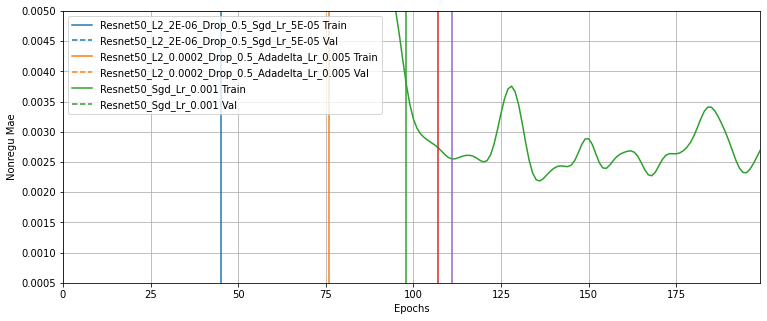

In [ ]:
plt.figure(figsize=(12.5, 5))
plotter.plot(histories)
epoch_set = set()
for name in epoch_record.keys():
    epoch_set.update(set(epoch_record[name]))
epoch_set = sorted(list(epoch_set))
for i in range(len(epoch_set) - 1):
    plt.plot([epoch_set[i] - 1, epoch_set[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([140, 170])
plt.ylim([0.0005, 0.005])
plt.xlabel('Epochs')
print(lr_record)
print(epoch_record)

```
{'ResNet50_SGD_lr_0.001': [1.0000001e-05, 1e-06, 1e-07, 9.9999994e-11]}
{'ResNet50_SGD_lr_0.001': [49, 59, 99, 149]}
```
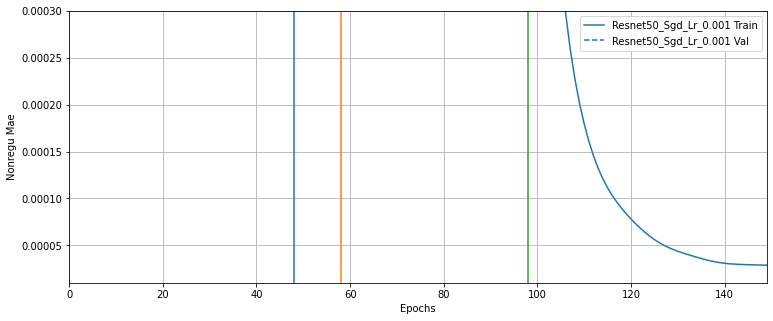


===> có vẻ như ResNet50 overfit quá tốt cho tiny: < 0.00005 train loss được

#### Thử overfit ResNet50 trên tập dữ liệu đầy đủ

In [ ]:
optimizer = SGD(learning_rate=5e-3, momentum=0.9, nesterov=True)

model = ResNet50()

name = '{}_{}_lr_{}'.format(model.name, optimizer.get_config()['name'], optimizer.get_config()['learning_rate'])
models[name] = model

In [ ]:
optimizer = SGD(learning_rate=5e-5, momentum=0.9, nesterov=True)
train_model(name, optimizer, max_epochs=350, monitor='nonregu_mae', reduce_lr_patience=10, batch_size=128)

{'ResNet50_SGD_lr_0.005': [4.9999995e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-06]}
{'ResNet50_SGD_lr_0.005': [105, 119, 149, 199, 249, 320]}


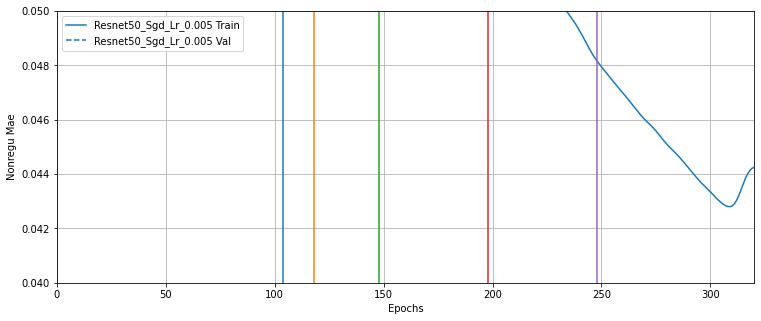

In [ ]:
plt.figure(figsize=(12.5, 5))
plotter.plot(histories)
epoch_set = set()
for name in epoch_record.keys():
    epoch_set.update(set(epoch_record[name]))
epoch_set = sorted(list(epoch_set))
for i in range(len(epoch_set) - 1):
    plt.plot([epoch_set[i] - 1, epoch_set[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([140, 170])
plt.ylim([0.04, 0.05])
plt.xlabel('Epochs')
print(lr_record)
print(epoch_record)

===> có vẻ khó overfit đến mức 0.001 được

#### coarse optimizer khác

In [ ]:
def coarse(model, optimizer, max_epochs, monitor, reduce_lr_patience):
    name = '{}_{}_lr_{}'.format(model.name, optimizer.get_config()['name'], optimizer.get_config()['learning_rate'])
    models[name] = model
    train_model(name, optimizer, max_epochs=max_epochs, monitor=monitor, reduce_lr_patience=patience, batch_size=128)

In [ ]:
coarse(ResNet50(), Adam(learning_rate=5e-3), 30, monitor='nonregu_mae', reduce_lr_patience=5)

In [ ]:
coarse(ResNet50(), Adam(learning_rate=5e-4), 2, monitor='nonregu_mae', reduce_lr_patience=5)

In [ ]:
coarse(ResNet50(), Adadelta(learning_rate=5e-3), 30, monitor='nonregu_mae', reduce_lr_patience=5)

In [ ]:
coarse(ResNet50(), Adadelta(learning_rate=5e-4), 30, monitor='nonregu_mae', reduce_lr_patience=5)

In [ ]:
coarse(ResNet50(), SGD(learning_rate=1e-4, momentum=0.9, nesterov=True), 30, monitor='nonregu_mae', reduce_lr_patience=5)

In [ ]:
coarse(ResNet50(), SGD(learning_rate=1e-5, momentum=0.9, nesterov=True), 30, monitor='nonregu_mae', reduce_lr_patience=5)

chọn Adam lr=5e-4 để đi tiếp

In [ ]:
train_model('ResNet50_Adam_lr_0.0005', Adam(learning_rate=5e-9), max_epochs=500, monitor='nonregu_mae', reduce_lr_patience=20, batch_size=128)

{'ResNet50_Adam_lr_0.0005': [0.0005, 0.0005, 5e-06, 5e-07, 5e-09]}
{'ResNet50_Adam_lr_0.0005': [1, 125, 299, 364, 429]}


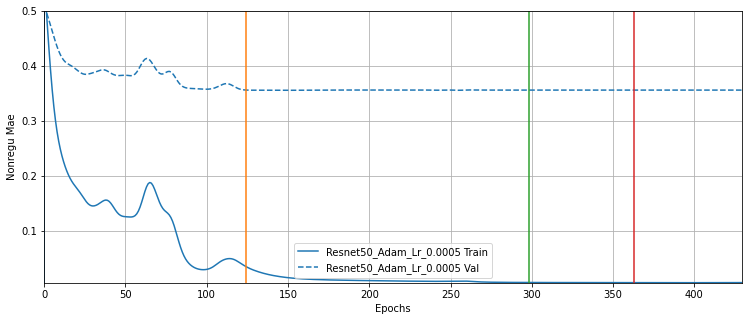

In [ ]:
plt.figure(figsize=(12.5, 5))
plotter.plot(histories)
epoch_set = set()
for name in epoch_record.keys():
    epoch_set.update(set(epoch_record[name]))
epoch_set = sorted(list(epoch_set))
for i in range(len(epoch_set) - 1):
    plt.plot([epoch_set[i] - 1, epoch_set[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([0, 100])
plt.ylim([0.005, 0.5])
plt.xlabel('Epochs')
print(lr_record)
print(epoch_record)

0.005 (train) - 0.37 (val)

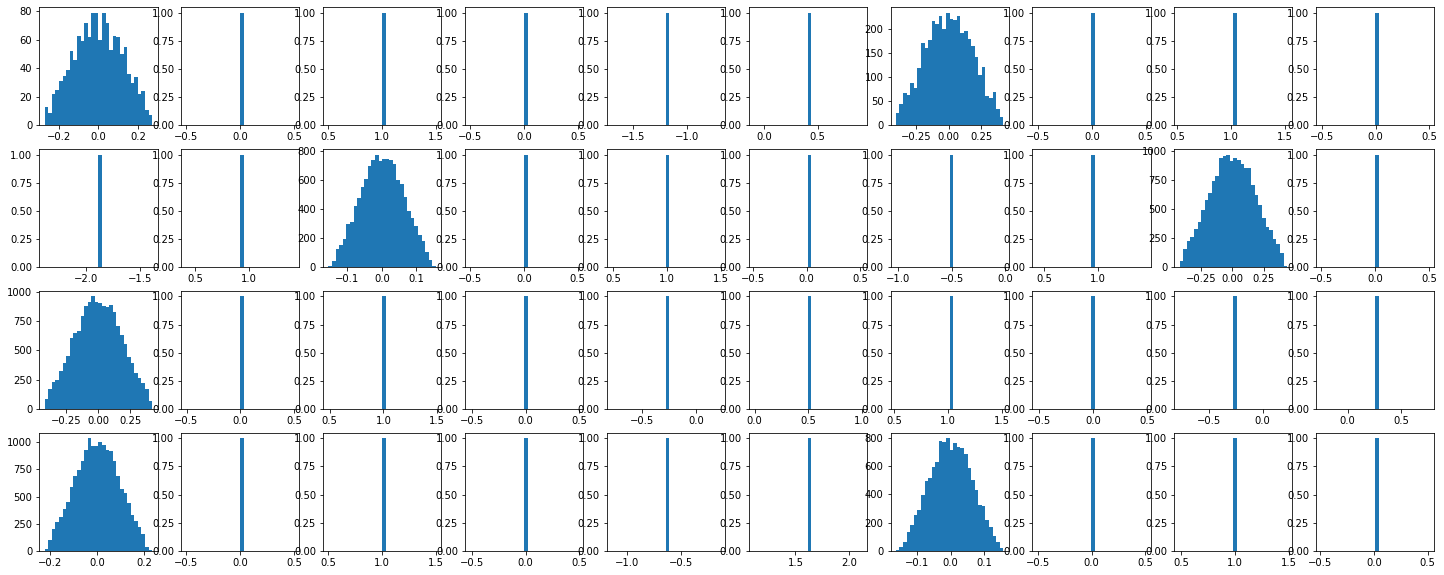

In [ ]:
plt.figure(figsize=(25, 10))
for i in range(40):
    plt.subplot(4, 10, i + 1)
    plt.hist(models['ResNet50_Adam_lr_0.0005'].get_weights()[i][0].reshape(-1,), bins=30)

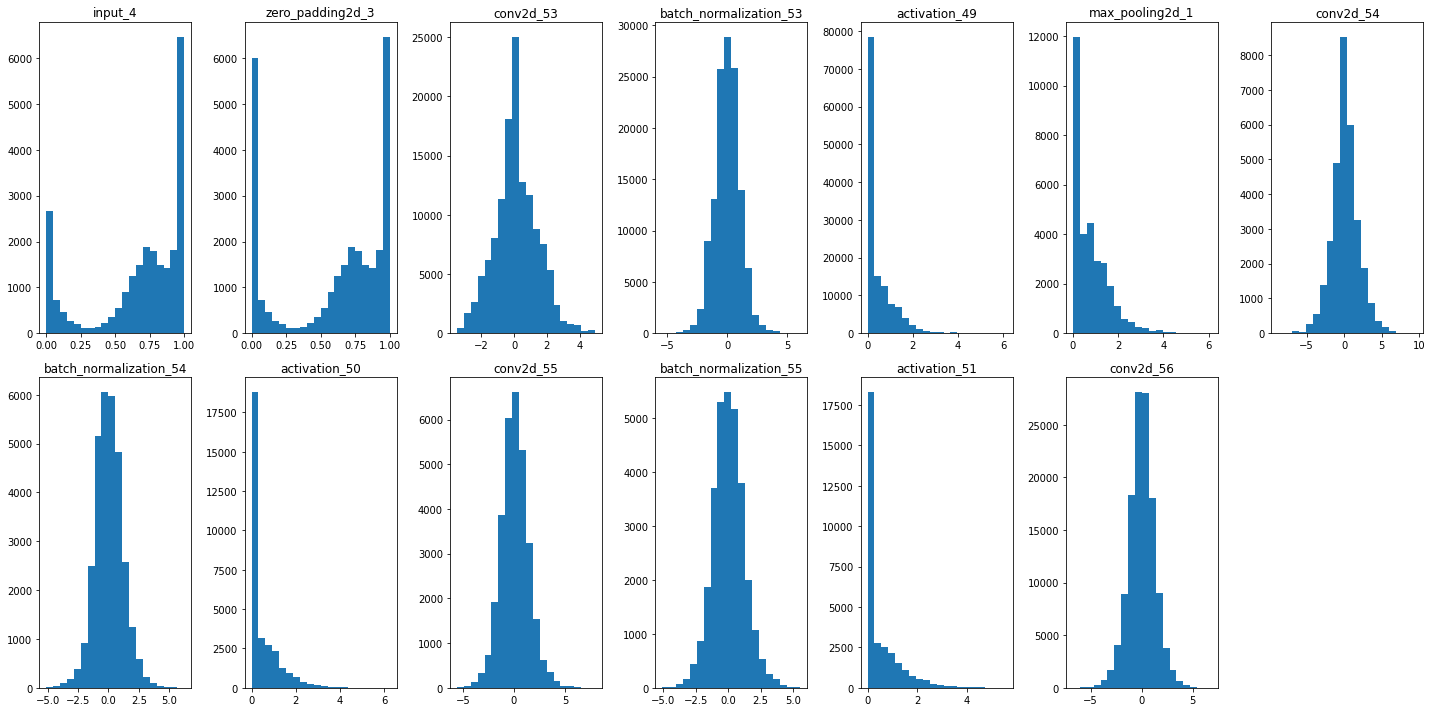

In [ ]:
plot_activations(models['ResNet50_Adam_lr_0.0005'], images[24])

In [ ]:
weights = [w[0].reshape(-1,) for w in models['ResNet50_Adam_lr_0.0005'].get_weights()]

In [ ]:
sum([np.sum(np.square(w)) for w in weights])

56982.41215229624

#### Tạo ResNet50 regu

In [ ]:
def identity_block_regu(X, f, filters, training=True, l=None, dropout_rate=0):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    set_seed(seed)

    # retrieve filters
    F1, F2, F3 = filters

    # save the input value
    X_shortcut = X

    # first component of main path
    X = Conv2D(filters=F1, kernel_size=1, strides=1, padding='valid', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    # X = Dropout(dropout_rate)(X)

    # second component of main path
    X = Conv2D(filters=F2, kernel_size=f, strides=1, padding='same', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    # X = Dropout(dropout_rate)(X)

    # third component of main path
    X = Conv2D(filters=F3, kernel_size=1, strides=1, padding='valid', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    # X = Dropout(dropout_rate)(X)

    # add shortcut value to main path and pass it through a RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

    

In [ ]:
def convolutional_block_regu(X, f, filters, s=2, training=True, l=None, dropout_rate=0):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    set_seed(seed)

    # retrieve filters
    F1, F2, F3 = filters

    # save the input value
    X_shortcut = X

    # first component of main path
    X = Conv2D(F1, kernel_size=1, strides=s, padding='valid', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    # X = Dropout(dropout_rate)(X)

    # second component of main path
    X = Conv2D(F2, kernel_size=f, strides=1, padding='same', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    # X = Dropout(dropout_rate)(X)

    # third component of main path
    X = Conv2D(F3, kernel_size=1, strides=1, padding='valid', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    # X = Dropout(dropout_rate)(X)

    # shortcut path
    X_shortcut = Conv2D(F3, kernel_size=1, strides=s, padding='valid', kernel_initializer=he_normal(seed=seed))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)
    # X = Dropout(dropout_rate)(X)

    # add shortcut to main path, and pass it through a RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet50_regu(input_shape=input_shape, l=None, dropout_rate=0):

    set_seed(seed)

    X_input = Input(input_shape)

    X = ZeroPadding2D(padding=3)(X_input)

    # define the input as a tensor
    X_input= Input(input_shape)

    # zero-padding
    X = ZeroPadding2D(padding=3)(X_input)

    # stage 1
    X = Conv2D(filters=64, kernel_size=7, strides=2, kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=3, strides=2)(X)
    # X = Dropout(dropout_rate)(X)

    # stage 2
    X = convolutional_block_regu(X, f=3, filters=[64, 64, 256], s=1, dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[64, 64, 256], dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[64, 64, 256], dropout_rate=dropout_rate)

    # stage 3
    X = convolutional_block_regu(X, f=3, filters=[128, 128, 512], s=2, dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[128, 128, 512], dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[128, 128, 512], dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[128, 128, 512], dropout_rate=dropout_rate)

    # stage 4
    X = convolutional_block_regu(X, f=3, filters=[256, 256, 1024], s=2, dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[256, 256, 1024], dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[256, 256, 1024], dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[256, 256, 1024], dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[256, 256, 1024], dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[256, 256, 1024], dropout_rate=dropout_rate)

    # stage 5
    X = convolutional_block_regu(X, f=3, filters=[512, 512, 2048], s=2, dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[512, 512, 2048], dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[512, 512, 2048], dropout_rate=dropout_rate)

    # average pooling layer
    X = GlobalAveragePooling2D(name="avg_pool")(X)
    X = Dense(2048, activation='relu', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)
    X = Dense(512, activation='relu', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)
    X = Dense(128, activation='relu', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)
    X = Dense(32, activation='relu', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)
    X = Dense(1, kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)

    # create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50_L2_{}_drop_{}'.format(str(l.l2 if l is not None else 0), dropout_rate))

    return model


#### Thử overfit trên tập rất bé

In [ ]:
remove_model('ResNet50_L2_2e-05_drop_0.5_Adam_lr_0.005')

In [ ]:
optimizer = Adadelta(learning_rate=5e-3)#SGD(5e-5, momentum=0.9, nesterov=True)

model = ResNet50_regu(l=L2(2e-4), dropout_rate=0.5)

name = '{}_{}_lr_{}'.format(model.name, optimizer.get_config()['name'], optimizer.get_config()['learning_rate'])
models[name] = model

In [ ]:
optimizer = Adadelta(learning_rate=5e-4)#SGD(5e-5, momentum=0.9, nesterov=True)
train_model(name, optimizer, max_epochs=100, monitor='loss', reduce_lr_patience=15, dataset_size='tiny')

{'ResNet50_L2_2e-06_drop_0.5_SGD_lr_5e-05': [5e-06], 'ResNet50_L2_0.0002_drop_0.5_Adadelta_lr_0.005': [0.00049999997, 0.0005]}
{'ResNet50_L2_2e-06_drop_0.5_SGD_lr_5e-05': [108], 'ResNet50_L2_0.0002_drop_0.5_Adadelta_lr_0.005': [46, 99]}


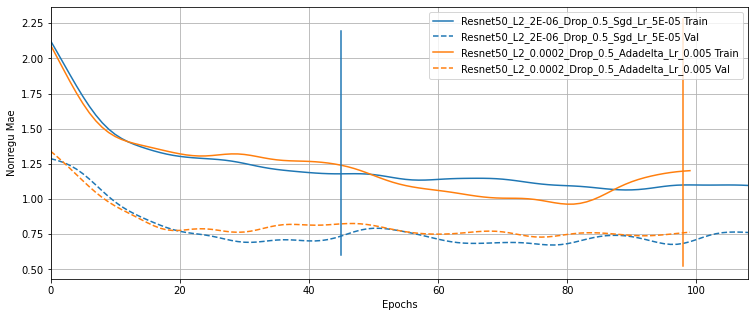

In [ ]:
plt.figure(figsize=(12.5, 5))
plotter.plot(histories)
epoch_set = set()
for name in epoch_record.keys():
    epoch_set.update(set(epoch_record[name]))
epoch_set = sorted(list(epoch_set))
for i in range(len(epoch_set) - 1):
    plt.plot([epoch_set[i] - 1, epoch_set[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([0, 100])
# plt.ylim([0, 2])
plt.xlabel('Epochs')
print(lr_record)
print(epoch_record)

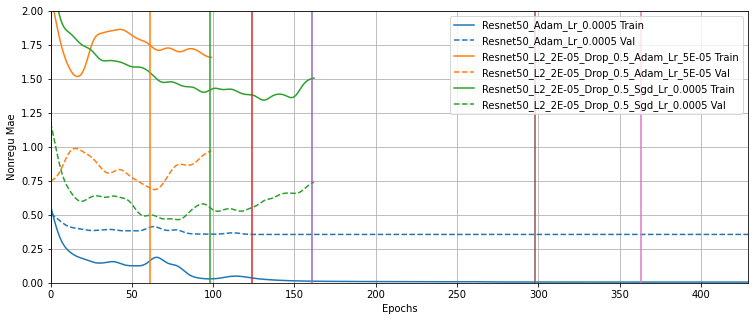

#### make sure can overfit

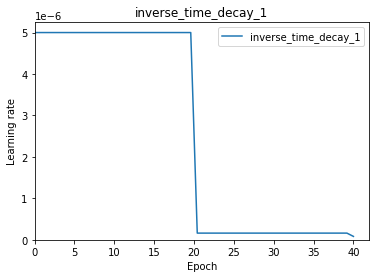

In [ ]:
inverse_time_decay_1 = InverseTimeDecay(
    initial_learning_rate=5e-6,
    decay_steps=steps_per_epoch*20,
    decay_rate=30,
    staircase=True,
    name='inverse_time_decay_1'
)

step = np.linspace(0, steps_per_epoch * max_epochs)

plot_learning_rate(step, inverse_time_decay_1)

#### testing

In [ ]:
# Testing learning rate
l = L2(0.001)

# model without dropout
model = ResNet11_regu(input_shape)

optimizer = Adadelta(learning_rate=1e-2)


loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

2.3670883
1.2978877
0.7346019


In [ ]:
# check if the regu term is present

model.layers[2].get_config()

first, we check with tiny dataset

if the training is terminated because of callback, adjust the learning rate to smaller



In [ ]:
l = L2(0.001)

patience = 10
max_epochs = 20
steps_per_epoch = 5


lr = 1e-4
name = 'regu_0.001_adadelta_{}_tiny'.format(lr)
shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet11_regu(input_shape)

history = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    train_data=tiny_train_ds,
    validation_data=tiny_val_ds,
    callbacks=get_callback('optimizers/' + name)
)

plotter.plot({name: history})
plt.xlabel('Epochs')        # <---- add [Log scale]

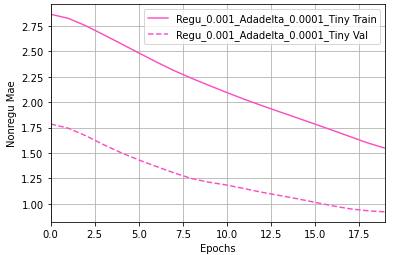

với 20 epochs fit khá tốt với tiny. nếu train thêm chắc sẽ overfit được

### TensorBoard

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir {logdir}/lr

In [ ]:
validation_data = get_dataset(32)[1]
predictions = tf.data.Dataset.from_tensor_slices(np.squeeze(model.predict(validation_data))).batch(32)

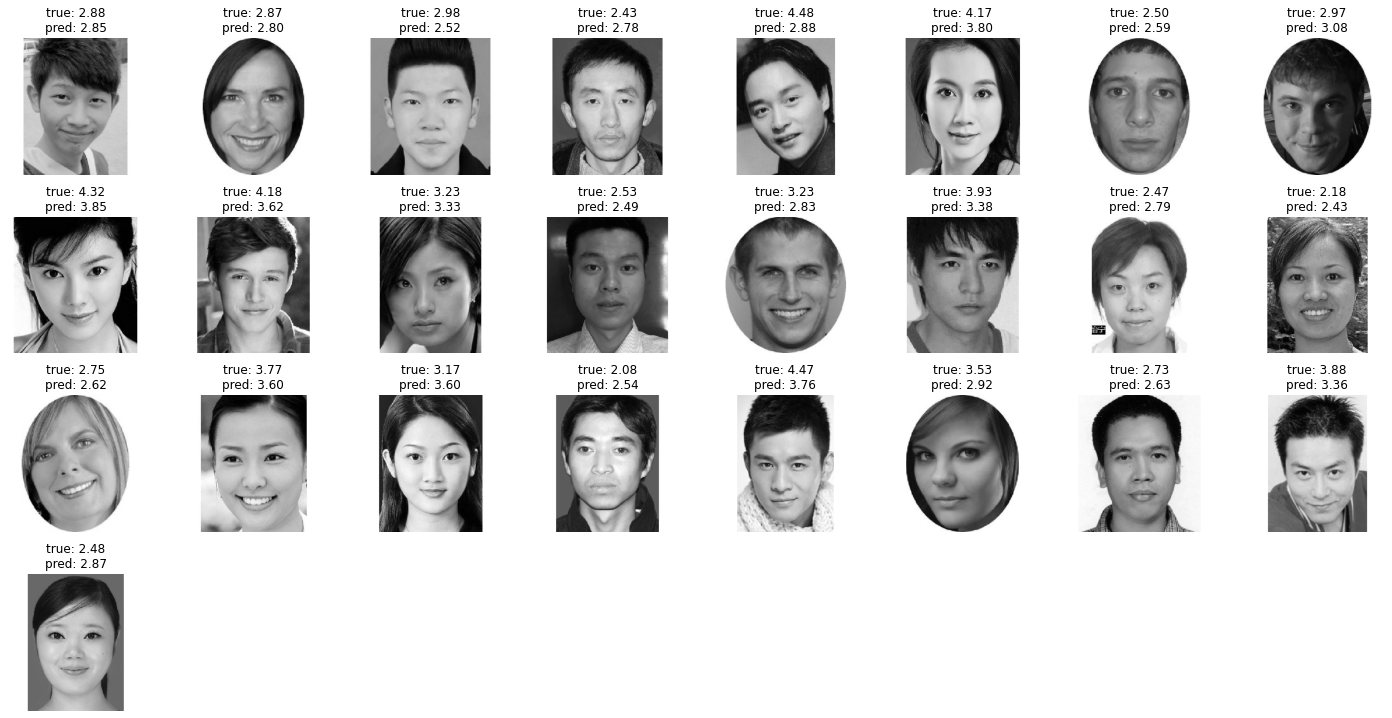

In [ ]:
plt.figure(figsize=(20, 20))
for imgs, true_scores in validation_data.take(1):
    for pred_scores in predictions.take(1):
        for i in range(25):
            ax = plt.subplot(8, 8, i + 1)
            plt.imshow(np.squeeze(imgs[i]), cmap='gray')
            plt.title('true: {:.2f}\npred: {:.2f}'.format(true_scores[i], pred_scores[i]))
            plt.tight_layout()
            plt.axis("off")